# Simulating null distributions for outlier scans

In [23]:
import msprime, tskit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import Fst_ts_thread_interval as F

ModuleNotFoundError: No module named 'Fst_ts_thread_interval'

We are interested in understanding the divergence between two species and have been analysing Fst in windows of 32kb for a sample of 2 diploid individuals per species and have observed some tantalizing outliers. Let's (for now) assume that we have concrete information on the background demography and have estimated parameters under very simple null model of divergence with gene flow. An obvious questions is:
- How likely windows with extreme Fst outliers given this history (and sample size)?


## Divergence with constant migration

Our cartoon history estimated from genome-wide data (we will give an example of how to do this using GimBL tomorrow) has four parameters: a population split time ($T$ in generations) between pop0 and pop1, a constant rate of unidirectional gene flow ($m$ per generation) and two effective population sizes (we assume that the common ancestral pop has the same effective size as pop0). We assume:

- sequence windows of length 32kb, with a per base recombination rate 1.84 10^-8 (average $r$ given the Heliconius map from Davey et al. 2017)

- gene flow from pop1 to pop0 only

This sets up the sampling configuration and demographic history in msprime:

In [114]:
#number of samples (2Xof diploid individuals) per deme:
sample_size = 2

#Rates for migration, recombination and mutation are unscaled and per generation:
mig = 3.8866e-7
seqLength = 32e3 
recr = 1.84675e-8
Ne0 = 2.3241e6
Ne1 = 9.8922e5 
splitT = 4.8580e6
mu = 1.9e-9

population_configurations = [
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne0),
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne1),
    ]
#demographic events are specified in the order they occur backwards in time:
# The MassMigration specifies the split between population 0 and 1: 
# backwards in time all lineages from the smaller population (1) are derived from pop (0)
# at time T 
demographic_events = [
    msprime.MassMigration(time=splitT, source=1, destination=0, proportion=1.0),
    ]
# migration matrix specifies a matrix of pairwise migration rates (backwards in time).
#migration_matrix = [[0,0],
#                    [mig,0]]

We want to simulate 200 replicate windows under this history in msprime. Simulations are pseudorandom, i.e. we start by generating a vector of random seeds.

In [115]:
num_reps = 200
seed = np.random.randint(1, 2**32 - 1, 1)
#seed = np.random.randint(1, 2**32 - 1, 1)
replicates = msprime.simulate(
        num_replicates = num_reps,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix = [[0,0],[mig,0]],
        mutation_rate = mu,
        random_seed=seed)

We can sprinkle mutations onto the treesequence and save variants as a vcf file as well as saving the treesequences themselves:

In [107]:
for index, ts in enumerate(replicates):
#    msprime.mutate(ts, rate=mu, keep=True)
    with open('sim{}.vcf'.format(str(index)), 'w') as vcf_file:
        ts.write_vcf(vcf_file, ploidy=2)
    ts.dump('sim{}.trees'.format(str(index)))

We have simulated treesequences with mutations sprinkled on them. A simple way to compute Fst for each replicate window is to compare.

We will use the following Fst definition:

$F_{st}= \frac{T_b-T_w}{T_b+T_w}$

where $T_w$ and $T_b$ are the average pairwise coalescence times for a pair of lineages sampled within and between species respectively. Therefore an estimator of $F_{st}$ is:

$\hat{F_{st}}= \frac{d_{xy}-\pi}{d_{xy}+\pi}$

Note that the above follows from the general definition of $F_{st}$ in terms of expected pairwise coalescence times:

$F_{st}= \frac{T_t-T_w}{T_{t}}$

Where $T_t$ is the average for a pairwise sample taken at random. For the case of pops/species we assume that we are equally likely to sample from within and between species, so.lkjlkjl

$T_t=(T_b + T_w)/2$

In [116]:
def comparisons(p1, p2):
    num_sites = p1.shape[0]
    num_comparisons = p1.shape[1]
    result = []
    for i in range(num_comparisons):
        p2 = np.roll(p2,1, axis=1)
        result.append(np.sum(np.mod(p1 + p2, 2))/num_sites)
    return result

def Fst(ts):
    G = ts.genotype_matrix()
    p1 = G[:,:2]
    p2 = G[:,2:4]
    within = (np.mean(comparisons(p1,p1)) + np.mean(comparisons(p2,p2)))/2
    between = np.mean(comparisons(p1, p2))
    total = np.mean([between, within])
    return (total - within)/total

We estimate $F_{st}$ for each replicate using the tskit function Fst() and store the results in a numpy array:

In [117]:
print(num_reps)

200


In [118]:
fstsim = np.zeros(num_reps)
for index, ts in enumerate(replicates):
    fstsim[index] = Fst(ts)
#    msprime.mutate(ts, rate=mu, keep=True)
#    with open('sim{}.vcf'.format(str(index)), 'w') as vcf_file:
#        ts.write_vcf(vcf_file, ploidy=2)
#   ts.dump('sim{}.trees'.format(str(index)))
#Fst(ts)

In [119]:
print(fstsim.mean())

0.48839915525511285


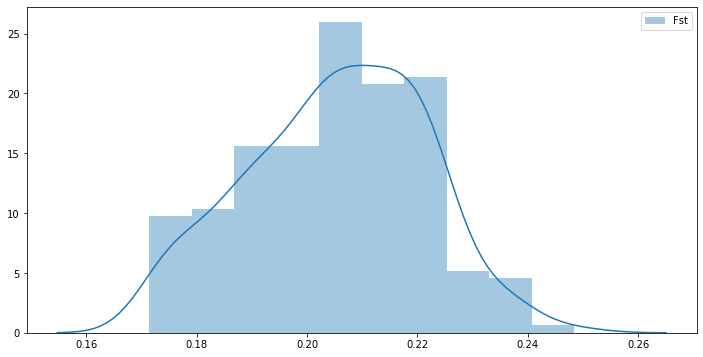

In [93]:
fig, ax = plt.subplots(figsize=(12,6))
sns.distplot(fstsim ,label='Fst')
#ax.set_xlim((1.2/1e8, 2.2/1e8))
#plt.legend()

In [75]:
#histogram for unlinked windows 32kb
basic_short = pd.read_csv('basic_short_all.csv')
basic_short.drop(basic_short.columns[[0, 1]], axis=1, inplace=True)
current_winner_short = pd.read_csv('current_winner_short_all.csv')
current_winner_short.drop(current_winner_short.columns[[0, 1]], axis=1, inplace=True)

In [66]:
current_winner_short.head()

,stop,Fst
0,31999,0.176737
1,31999,0.174984
2,31999,0.172102
3,31999,0.153665
4,31999,0.181024


(0, 0.5)

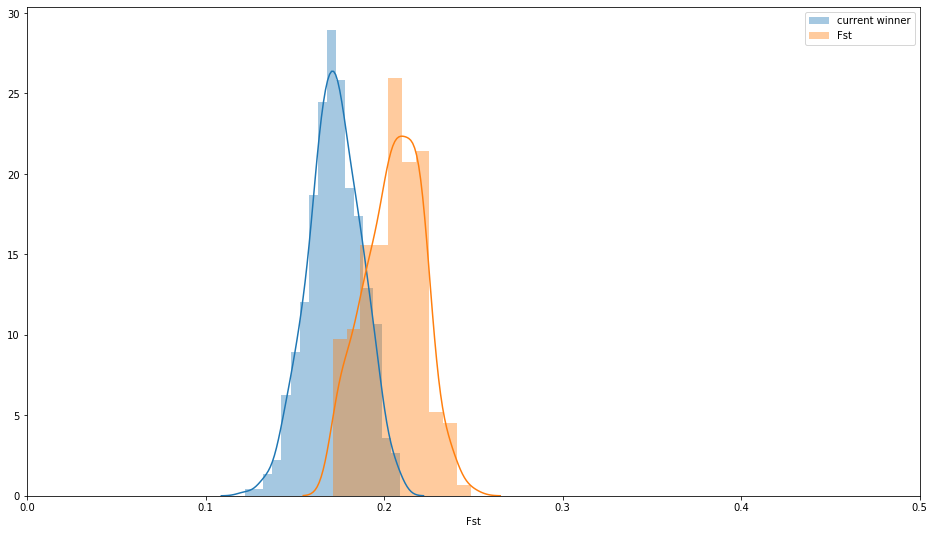

In [94]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(current_winner_short['Fst'], label='current winner', norm_hist=True)
sns.distplot(fstsim , label='Fst')
plt.legend()
ax.set_xlim((0, 0.5))

A faster alternative is to compute $F_{st}$ from the treesequence directly. This ignores the mutational variance in $F_{}$

In [111]:
def determine_windows(ts, windowsize, overlap):
	if overlap:
		assert windowsize%overlap==0, 'windowsize is not a multiple of the overlap'
		windows = [i*overlap for i in range(int(ts.sequence_length)//overlap+1)]
	else:
		windows = [i*windowsize for i in range(int(ts.sequence_length)//windowsize+1)]
	
	if windows[-1] != ts.sequence_length:
			windows.append(int(ts.sequence_length))

def Fst(div_entry):
	A = np.mean((div_entry.diagonal()))
	B = div_entry[1,0]
	return (B-A)/(A+B)

def calculate_Fst(ts, samplesets, windowsize, overlap=None):
	'''
	samplesets = [p1, p2]

	'''
	windowsize=int(windowsize)
	windows = determine_windows(ts, windowsize, overlap)
	branchStat=tskit.BranchLengthStatCalculator(ts)    
	div_matrix = branchStat.divergence_matrix(samplesets, windows)
	if overlap:
		jump = windowsize//overlap + 1
		div_matrix = np.mean([div_matrix[i:i+6] for i in range(len(windows)-6)],axis=1)

	Fst = [Fst(entry) for entry in with_overlap_mean]

	return Fst

p1 = ts.get_samples(0)
p2 = ts.get_samples(1)
fstSims = np.zeros(num_reps)
for index, ts in enumerate(replicates):
    fstSims [index] = calculate_Fst(ts,samplesets=[p1,p2], windowsize=32e3)[0]

ValueError: elements of sample_sets must be lists without repeated elements.

In [101]:
print(fstSims)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


or run all this in a script that can be run on multiple cores
change parametes within sim_chuncks.py as desired

In [24]:
%run sim_chuncks.py

ModuleNotFoundError: No module named 'tqdm'

run tskit Fst scan and
analyse output using script as provided in the Fst_istogram notebook

In [36]:
recomb = abs(np.random.normal(loc=1.846, scale=0.1, size=300))/1e8
replicates = msprime.simulate(
        num_replicates = 1,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix = [[0,0],
                            [mig,0]],
        mutation_rate = mu)

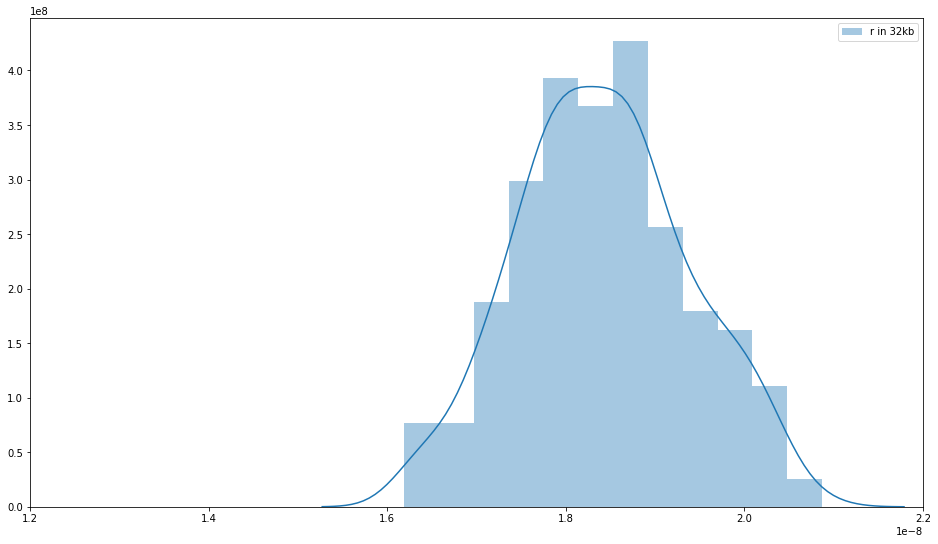

In [83]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(abs(np.random.normal(loc=1.846, scale=0.1, size=300))/1e8, label='r in 32kb')
ax.set_xlim((1.2/1e8, 2.2/1e8))
plt.legend()

In [63]:
#histogram for unlinked windows 32kb
basic_short = pd.read_csv('basic_short_all.csv')
basic_short.drop(basic_short.columns[[0, 1]], axis=1, inplace=True)
current_winner_short = pd.read_csv('current_winner_short_all.csv')
current_winner_short.drop(current_winner_short.columns[[0, 1]], axis=1, inplace=True)

## Divergence with secondary contact

How different is the distribution of $F_{st}$ if we assume that divergence happened in allopatry and has been partially eroded by secondary contact? We assume the same split time $T_{s}$ and $N_e$ as before and a sudden admixture event which transfers a proportion of $f=0.389$ from pop0 to pop1 at time $T_{ad}$. This is specified as another MassMigration event.

In [54]:
T = 4.8580e6
#time of secondary admixture
adT = 5.0772e4 
#proportion of lineages in source migrating into destination that split at time T:
proportionf =0.389 

population_configurations = [
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne0),
    msprime.PopulationConfiguration(sample_size=sample_size, initial_size=Ne1),
    ]
    
#demographic events: specify in the order they occur backwards in time.
demographic_events = [
    msprime.MassMigration(time=adT, source=1, destination=0, proportion=proportionf),
    msprime.PopulationParametersChange(time=T, initial_size=Ne0, population_id=0),
    msprime.MassMigration(time=T, source=1, destination=0, proportion=1.0)
    ]

replicatesAD = msprime.simulate(
        num_replicates = num_reps,
        length = seqLength, 
        recombination_rate = recr,
        population_configurations = population_configurations,
        demographic_events = demographic_events)

In [53]:
fstsimAD = np.zeros(reps)

print(fstsimAD)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [55]:
fstsim = np.zeros(reps)
for index, ts in enumerate(replicatesAD):
    fstsim[index] = Fst(ts)

/home/konrad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


## Recombination rate heterogeneity

heli_32kb_Davey2017_rec is a dataframe with recombination rate estimates (cM/Mb) in 32kb windows estimated for Heliconius (Davey et al. 2017 generated three recombination maps for Hmel, Hcyd and the F1, the last column is the mean of these maps).

In [54]:
hapmap = pd.read_csv('heli_32kb_Davey2017_rec.csv', delimiter='\t')
hapmap.head()
#hapmap[hapmap['Chrom']==18]

,Chrom,start,end,Hmel,Hcyd,F1,Mean
0,1,465,93948,1.6382,3.3865,1.3737,2.1328
1,1,18722,109081,1.6372,3.3698,1.4416,2.1495
2,1,39996,116184,1.6364,3.3562,1.4992,2.1639
3,1,66980,122860,1.6355,3.3415,1.5672,2.1814
4,1,85341,131077,1.6349,3.3310,1.6206,2.1955


Note that 32kb is the total length of sequence in a window after filtering (in this case only intergenic data). So windows are substantially longer than 32 kb in terms of physical span: 

median = 70.566kb


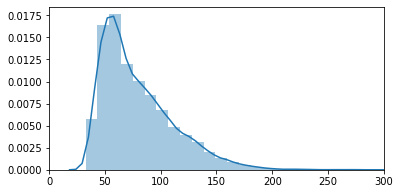

In [95]:
winspan=(hapmap['end']-hapmap['start'])/1000
fig, ax = plt.subplots(figsize=(6,3))
sns.distplot(winspan, label='window span')
ax.set_xlim((0, 300))
print("median = "+ str(winspan.median())+"kb")

2.015040450200432


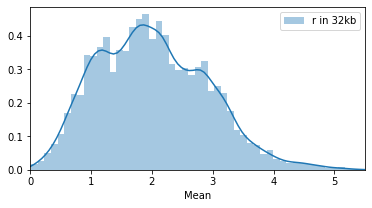

In [89]:
print(hapmap['Mean'].mean()/2)

fig, ax = plt.subplots(figsize=(6,3))
sns.distplot(hapmap['Mean']/2, label='r in 32kb')
ax.set_xlim((0, 5.5))
plt.legend()

We can draw a random sample of those values, run the msprime simulation again and compare this to the outcome we obtained without recombination rate variation.
Simulating 100 replicate windows is fast:

In [96]:
#simulate replicates with different recombination rates cfr. windows 
#specify a distribution to draw values from
recomb = np.random.choice(hapmap['Mean']/2,size=500)

In [98]:
replicates = [msprime.simulate(
        length = seqLength, 
        recombination_rate = rate/10e8,
        population_configurations = population_configurations,
        demographic_events = demographic_events,
        migration_matrix =  migration_matrix,
        mutation_rate = mu) 
for rate in recomb]